In [1]:
%run setup.py
# %config IPython.matplotlib.backend = "retina"

# Lower and Upper limits Sharma11

In [2]:
path=work_path+"sample/heb/sharpness/sharma16/"
relations = ["dnu", "numax", "mass", "radius"]
names = ["$\Delta\\nu$", "$\\nu_{\\rm max}$", "$M$", "$R$"]
lnames = ["\Dnu{}", "\\numax{}", "$M$", "$R$"]
llim, ellim, ulim, eulim = [np.zeros(4) for i in range(4)]
for i in range(4):
    data = np.load(path+relations[i]+"/llim/data.npy",allow_pickle=True).tolist()
    llim[i], ellim[i] = data['para_fit'][1], data['e_para_fit'][1]
    data = np.load(path+relations[i]+"/ulim/data.npy",allow_pickle=True).tolist()
    ulim[i], eulim[i] = data['para_fit'][1], data['e_para_fit'][1]


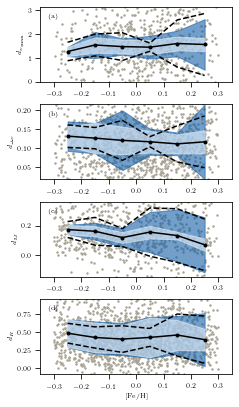

In [7]:
rootpath = "/Volumes/Data/Onedrive/Work/nike/"
import numpy as np 
import matplotlib
import sys
sys.path.append(rootpath) 
from lib.histdist import model6, distfit, distance_to_edge, reduce_samples
# from lib.wrapper import sharpness_fit_perturb_llim_mcmc, sharpness_fit_perturb_ulim_mcmc#sharpness_fit_rescale_mcmc
import os

diagrams = ['tnu', 'tnu', 'mr', 'mr']
distances = ['horizontal', 'vertical', 'horizontal', 'vertical']
variables = ['numax', 'dnu', 'mass', 'radius']
variables_latex = ['\\nu_{\\rm max}', '\Delta\\nu', 'M', 'R']
labels = ['(a)', '(b)', '(c)', '(d)']

fig, axes = plt.subplots(figsize=mnras_size(ratio=1.7), nrows=4, ncols=1, squeeze=False)
axes = axes.reshape(-1)
    
for i in range(4):
    # fdnu corrected sharma+2016
    obsdir = rootpath+"sample/heb/yu/feh/"
    moddir = rootpath+"sample/heb/padova/feh/"

    diagram, distance, var, varl = diagrams[i], distances[i], variables[i], variables_latex[i]

    # trial 4: feh effect

    fehs = np.arange(-0.3, 0.4, 0.1)
    fehs = (fehs[:-1]+fehs[1:])/2.
    Nbin = fehs.shape[0]
    zvalue_name = "feh"
    
    ulims, llims, sigmas, ymeds = [np.zeros(Nbin) for j in range(4)]
    
    for ibin in range(Nbin):
        # read in data
        obs = np.load(obsdir+"{:0.0f}/apk18.npy".format(ibin), allow_pickle=True).tolist()
        pdv = np.load(moddir+"{:0.0f}/padova.npy".format(ibin), allow_pickle=True).tolist()

        # We only test a subset of stars. 
        # For the rest, there seems to be a disagreement between Galaxia and Kepler.
        idx = (obs["mass"]<=1.9) & (obs["mass"]>=0.8)
        for key in obs.keys():
            obs[key] = obs[key][idx]

        idx = (pdv["mass"]<=1.9) & (pdv["mass"]>=0.8)
        for key in pdv.keys():
            pdv[key] = pdv[key][idx]   
        
        # read in edges
        if diagram == 'tnu':
            edges_obs = np.load(obsdir+"{:0.0f}/tnu_edge_samples.npy".format(ibin))
            tck_obs, tp_obs = np.load(obsdir+"{:0.0f}/nike_spline_tck.npy".format(ibin), allow_pickle=True)
            edges_pdv = np.load(moddir+"{:0.0f}/tnu_edge_samples.npy".format(ibin))
            tck_pdv, tp_pdv = np.load(moddir+"{:0.0f}/nike_spline_tck.npy".format(ibin), allow_pickle=True)

            if distance == 'horizontal': # numax
                # to exclude those points which lies below the edge (so no horizontal distance).
                idx = obs["dnu"]>=np.min(edges_obs[:,1])
                for key in obs.keys():
                    obs[key] = obs[key][idx]
                idx = pdv["dnu"]>=np.min(edges_pdv[:,1])
                for key in pdv.keys():
                    pdv[key] = pdv[key][idx]
            if distance == 'vertical': # dnu
                # to exclude those points which lies left to the edge (so no vertical distance).
                idx = obs["numax"]>=np.min(edges_obs[:,0])
                for key in obs.keys():
                    obs[key] = obs[key][idx]
                idx = pdv["numax"]>=np.min(edges_pdv[:,0])
                for key in pdv.keys():
                    pdv[key] = pdv[key][idx]

            xobs, yobs = obs["numax"], obs["dnu"]
            e_xobs, e_yobs = obs["e_numax"]/obs["numax"], obs["e_dnu"]/obs["dnu"]
            xpdv, ypdv = pdv["numax"], pdv["dnu"]

        if diagram == 'mr':
            edges_obs = np.load(obsdir+"{:0.0f}/mr_edge_samples.npy".format(ibin))
            tck_obs, tp_obs = np.load(obsdir+"{:0.0f}/mr_spline_tck.npy".format(ibin), allow_pickle=True)
            edges_pdv = np.load(moddir+"{:0.0f}/mr_edge_samples.npy".format(ibin))
            tck_pdv, tp_pdv = np.load(moddir+"{:0.0f}/mr_spline_tck.npy".format(ibin), allow_pickle=True)

            if distance == 'horizontal': # mass
                # to exclude those points which lies below the edge (so no horizontal distance).
                idx = obs["radius"] <= np.max(edges_obs[:,1])
                for key in obs.keys():
                    obs[key] = obs[key][idx]   
                idx = pdv["radius"] <= np.max(edges_obs[:,1])
                for key in pdv.keys():
                    pdv[key] = pdv[key][idx]
            if distance == 'vertical': # radius
                # nothing to exclude
                pass

            xobs, yobs = obs["mass"], obs["radius"]
            e_xobs, e_yobs = obs["e_mass"]/obs["mass"], obs["e_radius"]/obs["radius"]
            xpdv, ypdv = pdv["mass"], pdv["radius"]

            
        _, _, _, ridx = distance_to_edge(xobs, yobs, edges_obs[:,0], edges_obs[:,1], tck_obs, tp_obs, 
                                      diagram=diagram, distance=distance, return_idx=True)
        x = obs['feh'][ridx]
        
        
        # read in results
        # upper limits
        filepath = rootpath+"sample/heb/sharpness/sharma16/"+var+"_"+zvalue_name+"/ulim/{:0.0f}/".format(ibin)
        data = np.load(filepath+'data.npy',allow_pickle=True).tolist()
        y = data['obj_obs'].dist
        ymeds[ibin] = np.median(y)
        if distance=='horizontal':
            sigmas[ibin] = np.std(e_xobs[ridx]*xobs[ridx])
            obs = xobs[ridx]
        else:
            sigmas[ibin] = np.std(e_yobs[ridx]*yobs[ridx])
            obs = yobs[ridx]
        
        ulims[ibin] = data['para_fit'][-1] * np.median(obs)
        
        
        # lower limits
        filepath = rootpath+"sample/heb/sharpness/sharma16/"+var+"_"+zvalue_name+"/llim/{:0.0f}/".format(ibin)
        data = np.load(filepath+'data.npy',allow_pickle=True).tolist()

        ndim = 2
        para_fitmax = np.zeros(ndim)
        for ipara in range(ndim):
            n, bins = np.histogram(data['samples'][:,ipara], 80)
            idx = np.where(n == n.max())[0][0]
            para_fitmax[ipara] = bins[idx:idx+1].mean()     
    
        llims[ibin] = para_fitmax[-1] * np.median(obs)#data['para_fit'][-1] * np.median(obs)#
        
        # plot
        axes[i].scatter(x, y, c=grey, marker='.', s=8)

        
        
    axes[i].plot(fehs, ymeds, 'k.')
    axes[i].plot(fehs, ymeds, 'k-')
    axes[i].plot(fehs, ymeds+ulims, 'k--')
    axes[i].plot(fehs, ymeds-ulims, 'k--')
    axes[i].fill_between(fehs, ymeds+sigmas+llims, ymeds-sigmas-llims, 
                         color=blues()[-2], alpha=0.6)
    axes[i].fill_between(fehs, ymeds+sigmas, ymeds-sigmas, 
                         color=blues()[0], alpha=0.6)
    axes[i].axis([-0.35, 0.35, np.min(ymeds-sigmas-ulims), np.max(ymeds+sigmas+ulims)])
    axes[i].set_ylabel('$d_{'+varl+'}$')
    axes[i].text(0.04, 0.85, labels[i], transform=axes[i].transAxes, zorder=10)

axes[-1].set_xlabel('[Fe/H]')
plt.tight_layout()
plt.savefig(overleaf_path+'feh.pdf')

In [5]:
print(data.keys())

dict_keys(['samples', 'ndim', 'para_fit', 'e_para_fit', 'para_guess', 'diagram', 'distance', 'xobs', 'yobs', 'xpdv', 'ypdv', 'xfit', 'yfit', 'obj_obs', 'obj_pdv', 'obj_fit', 'number_reduction_factor'])
